In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


**Loaded in this way, each of the batch files contains a dictionary with the following elements:**

data -- a 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.

labels -- a list of 10000 numbers in the range 0-9. The number at index i indicates the label of the ith image in the array data.

The dataset contains another file, called batches.meta. It too contains a Python dictionary object. It has the following entries:

label_names -- a 10-element list which gives meaningful names to the numeric labels in the labels array described above. For example, label_names[0] == "airplane", label_names[1] == "automobile", etc.

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import euclidean_distances
import time

# Unpickle
def unpickle(file):
  import pickle
  with open(file, 'rb') as fo:
      dict = pickle.load(fo, encoding='bytes')
  return dict

t1 = unpickle('drive/My Drive/CS 498 AML/HW4/cifar-10-batches-py/data_batch_1')
t2 = unpickle('drive/My Drive/CS 498 AML/HW4/cifar-10-batches-py/data_batch_2')
t3 = unpickle('drive/My Drive/CS 498 AML/HW4/cifar-10-batches-py/data_batch_3')
t4 = unpickle('drive/My Drive/CS 498 AML/HW4/cifar-10-batches-py/data_batch_4')
t5 = unpickle('drive/My Drive/CS 498 AML/HW4/cifar-10-batches-py/data_batch_5')
t6 = unpickle('drive/My Drive/CS 498 AML/HW4/cifar-10-batches-py/test_batch')
meta = unpickle('drive/My Drive/CS 498 AML/HW4/cifar-10-batches-py/batches.meta')

# Create numpy array containing all datasets
data = np.concatenate((t1.get(b'data'),t2.get(b'data'),t3.get(b'data'),t4.get(b'data'),t5.get(b'data'),t6.get(b'data')), axis=0)
labels = np.concatenate((t1.get(b'labels'),t2.get(b'labels'),t3.get(b'labels'),t4.get(b'labels'),t5.get(b'labels'),t6.get(b'labels')))
labels = np.array([labels]).T
whole = np.concatenate((data,labels), axis=1)

**Part A**


Now for each image, compute the squared difference between the original and reconstructed version, and sum this over all pixels over all channels. If you have flattened your images, this is simply the squared euclidean distance between the image vectors. Take the average of the value you computed above over all images in the class.
Plot the above value in the bar graph against its category/class label. You will submit this plot.

1.   For each class, find the mean image, and compute the first 20 principal components.
2.   Now use the mean as well as the principle components to compute a low-dimensional reconstruction of each image in the class. Hint: Libary functions will come in handy here. Refer to section 7.1.2 and 7.1.3 for theory.
3.   Now for each image, compute the squared difference between the original and reconstructed version, and sum this over all pixels over all channels. If you have flattened your images, this is simply the squared euclidean distance between the image vectors. Take the average of the value you computed above over all images in the class.
4.   Plot the above value in the bar graph against its category/class label. You will submit this plot.



In [0]:
# Rearranging by label
# Feature mean by label
data_by_label = np.empty(10, dtype = np.ndarray)
mean_by_label = np.empty(10, dtype = np.ndarray)
for i in range(10):
  data_by_label[i] = whole[labels.T[0]==i,:3072]
  mean_by_label[i] = np.array([np.mean(data_by_label[i], axis=0)])

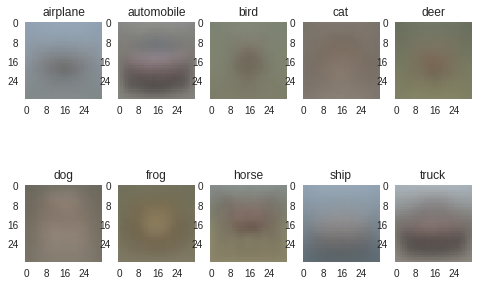

In [90]:
def plot_mean():
    for i in range(10):
        a = mean_by_label[i].reshape(3,32,32)
        red = a[0].reshape(1024,1)
        green = a[1].reshape(1024,1)
        blue = a[2].reshape(1024,1)

        pic = np.hstack((red,green,blue))
        pic_rgb = (pic.reshape(32,32,3))

        plt.subplot(2,5,i+1)
        plt.title(meta[b'label_names'][i].decode("utf-8"))
        plt.grid(False)
        plt.xticks(np.arange(0, 32, 8))
        plt.yticks(np.arange(0, 32, 8))
        plt.imshow(pic_rgb/255)

    plt.show()
plot_mean()

In [0]:
# Initiating MSE and 20-PC arrays
toOrig = np.empty(10, dtype = np.ndarray)
mse = np.empty(10, dtype = np.ndarray)

# Returns MSE
def MSE(x, p):
  mse = mean_squared_error(x, p, multioutput='raw_values').sum()
  return mse

# Returns matrix after PCA
def applyPCA(model, target, n_comp):
  # Number of PC
  pca = PCA(n_components = n_comp)

  # Train PCA model
  mod = pca.fit(model)

  # Apply transformation to target dataset
  recon = mod.transform(target - np.mean(target, axis=0))

  # Project back to original space
  toOrig = mod.inverse_transform(recon) + np.mean(target, axis=0)
  return toOrig

# Find MSE for each of 10 labels with 20 PC
for i in range(10):
  tar = data_by_label[i]
  toOrig[i] = applyPCA(tar, tar, 20)
  mse[i] = MSE(data_by_label[i],toOrig[i])


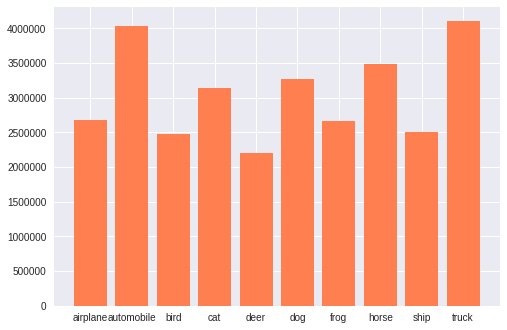

In [92]:
# Create a plot
plt.bar(meta[b'label_names'],mse, color='coral')
plt.show()

**Part B**

1.   Compute a 10 x 10 distance matrix `D` such that `D[i,j]` is the Euclidean distance between the mean images of class `i` and class `j`. Square the elements of this matrix and write it out to a CSV file named partb_distances.csv. You will submit this file.
Note: The order of the class labels is very important here, as this file will be autograded. Refer to this for the index-label mapping, and ensure yours matches.
2.   Now you must perform multi-dimensional scaling with the squared distance matrix you have. Refer to the MDS section for details on how to do that.
3.   Once you have computed the scaled points in 2-D space, plot the first component along the x-axis and component 2 along the y-axis of a scatter plot. You will submit this plot.



In [0]:
# Euclidian vector
D = np.empty([10,10])

def ED(x, p):
  ed = euclidean_distances(x, p, squared=True)
  return ed[0]

for i in range(10):
  for j in range(10):
    D[i,j] = ED(mean_by_label[i],mean_by_label[j])
    
# np.savetxt('drive/My Drive/CS 498 AML/HW4/partb_distances.csv', D, delimiter=',')

1.   First form the centering matrix A as described in section 7.1.2 on page 118. A = I - 1⁄N11T
2.   Now form W = -½AD(2)AT
3.   Next, form U and Λ such that WU = UΛ. These are respectively the eigenvectors and eigenvalues of W. Ensure that the entries of Λ are sorted in decreasing order. Notice that you need only the top s eigenvalues and their eigenvectors, and many packages can extract these quickly, instead of constructing all of them.
4.   Choose s, the number of dimensions you wish to represent. Form Λs, the top left s x s block of Λ.
5.   Form Λs½, whose entries are the positive square roots of Λs. Construct Us, the matrix consisting of the first s columns of U.
6.   Finally, compute Y = UsΛs½ . Each row in the result is a point you must plot.



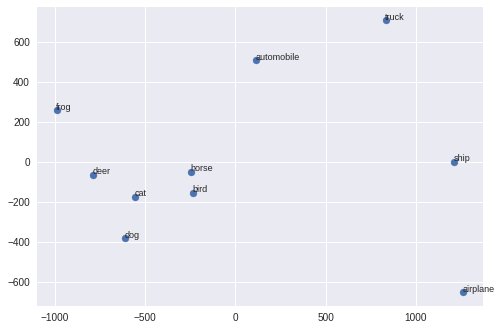

[[1261.04108257 -650.75260156]
 [ 115.25039988  508.19655201]
 [-233.19879181 -155.34258839]
 [-555.19510672 -172.91245086]
 [-787.31201042  -62.93220496]
 [-609.74487224 -382.12574181]
 [-986.99201827  257.57547421]
 [-246.76123738  -49.75162283]
 [1211.41570619    1.30131067]
 [ 831.49684819  706.74387352]]


In [94]:
# MDS
def plotMDS(D):
  A = np.identity(10) - 1/10*np.ones((10,1)) @ np.ones((1,10))
  W = -0.5 * A @ D @ A.T

  lam, U = np.linalg.eig(W)

  ind = lam.argsort()[::-1]

  lam = lam[ind]
  U = U[:,ind]

  lam = np.diagflat(lam)
  lam_s = lam[:2,:2]
  sqrt_lam_s = np.sqrt(lam_s)
  U_s = U[:,:2]

  Y = U_s @ sqrt_lam_s
  plt.scatter(Y[:,0],Y[:,1])
  for i in range(10): 
    plt.text(Y[i,0]-5, Y[i,1]+5, meta[b'label_names'][i].decode("utf-8") , fontsize=9)
  plt.show()
  print(Y)

plotMDS(D)

In [0]:
# Returns matrix after PCA
def applyPCAe(model, target, n_comp):
  # Number of PC
  pcaa = PCA(n_components = n_comp)
  pcab = PCA(n_components = n_comp)

  # Train PCA model
  moda = pcaa.fit(target)
  modb = pcab.fit(model)
  
  moda.components_ = modb.components_

  
  # Apply transformation to target dataset
  recon = moda.transform(target)

  # Project back to original space
  toOrig = moda.inverse_transform(recon)
  return toOrig

def E(a, b):
  x = applyPCAe(b, a, 20)
  e = MSE(x, a)
  return e

def E_atob(a, b):
  e_atob = 0.5*(E(a, b)+E(b, a))
  return e_atob

D_c = np.empty([10,10])

for i in range(10):
  for j in range(i,10):
    D_c[i,j] = E_atob(data_by_label[i],data_by_label[j])
    D_c[j,i] = D_c[i,j]


In [0]:
# np.savetxt('drive/My Drive/CS 498 AML/HW4/partc_distances.csv', D_c, delimiter=',')

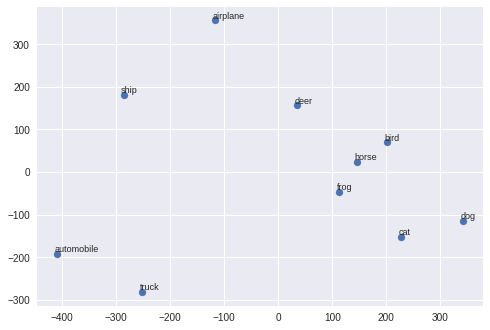

[[-117.13565338  356.26440878]
 [-408.95455849 -192.36075832]
 [ 200.49949612   69.47104965]
 [ 227.43725944 -151.76753401]
 [  34.67269189  156.93968421]
 [ 341.93658891 -115.16928105]
 [ 112.92001821  -45.87649728]
 [ 146.18744028   23.80015577]
 [-285.90955478  180.97750191]
 [-251.6537282  -282.27872967]]


In [97]:
plotMDS(D_c)

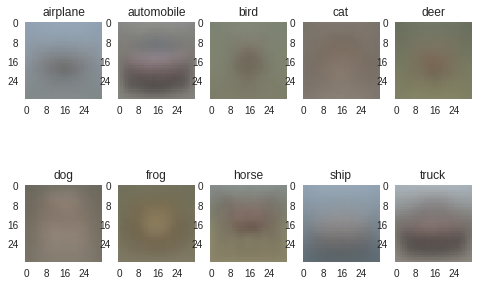

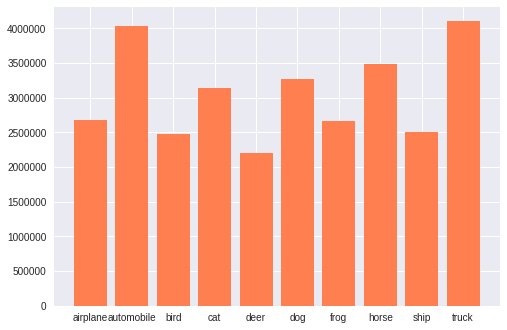

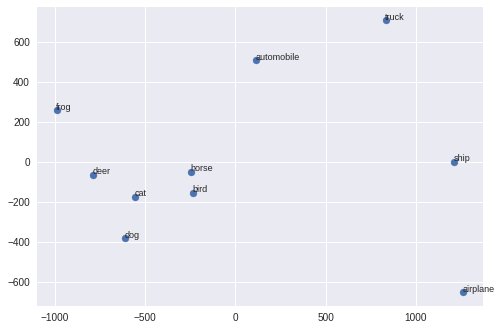

[[1261.04108257 -650.75260156]
 [ 115.25039988  508.19655201]
 [-233.19879181 -155.34258839]
 [-555.19510672 -172.91245086]
 [-787.31201042  -62.93220496]
 [-609.74487224 -382.12574181]
 [-986.99201827  257.57547421]
 [-246.76123738  -49.75162283]
 [1211.41570619    1.30131067]
 [ 831.49684819  706.74387352]]


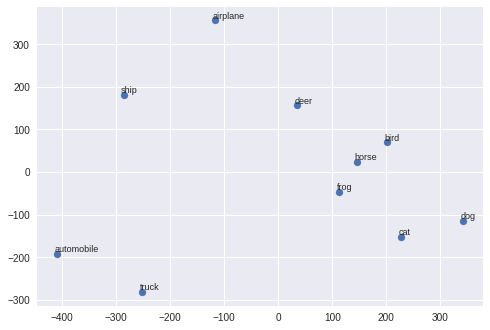

[[-117.13565338  356.26440878]
 [-408.95455849 -192.36075832]
 [ 200.49949612   69.47104965]
 [ 227.43725944 -151.76753401]
 [  34.67269189  156.93968421]
 [ 341.93658891 -115.16928105]
 [ 112.92001821  -45.87649728]
 [ 146.18744028   23.80015577]
 [-285.90955478  180.97750191]
 [-251.6537282  -282.27872967]]


In [98]:
plot_mean()
plt.bar(meta[b'label_names'],mse, color='coral')
plt.show()
plotMDS(D)
plotMDS(D_c)